## Pregunta 18 de Examen Final

### Instrucciones:

In relation to the book of Gujarati (basic econometrics), answer question 22.11 pp 799: Consider the data on log DPI (personal disposable income) introduced in Section 21.1 (see the book's website for the current data). Suppose you want to fit a suitable ARIMA model to these data. Outline the steps involved in carrying out this task

### Funciones re-utilizables

In [37]:
import pandas as pd
import numpy as np
from google.colab import files
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss, zivot_andrews
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

## Reusable functions
# Function for unit root tests with interpretation
def unit_root_tests(series, name):
    print(f"\nUnit Root Tests for {name}:")

    # ADF Test
    adf_result = adfuller(series)
    print("ADF Test:")
    print(f'ADF Statistic: {adf_result[0]:.4f}')
    print(f'p-value: {adf_result[1]:.4f}')
    print(f'Critical Values: {adf_result[4]}')
    print("INTERPRETATION:")
    if adf_result[1] < 0.05:
        print(f"  - p-value < 0.05: Reject null hypothesis - {name} is stationary")
    else:
        print(f"  - p-value >= 0.05: Fail to reject null - {name} may be non-stationary")

    # KPSS Test
    kpss_result = kpss(series)
    print("\nKPSS Test:")
    print(f'KPSS Statistic: {kpss_result[0]:.4f}')
    print(f'p-value: {kpss_result[1]:.4f}')
    print(f'Critical Values: {kpss_result[3]}')
    print("INTERPRETATION:")
    if kpss_result[1] < 0.05:
        print(f"  - p-value < 0.05: Reject null hypothesis - {name} is non-stationary")
    else:
        print(f"  - p-value >= 0.05: Fail to reject null - {name} may be stationary")

# Function to find best ARIMA model with interpretation
def find_best_arima(series, name, max_p=3, max_d=2, max_q=3):
    best_aic = float('inf')
    best_order = None

    for p in range(max_p + 1):
        for d in range(max_d + 1):
            for q in range(max_q + 1):
                try:
                    model = ARIMA(series, order=(p, d, q))
                    results = model.fit()
                    if results.aic < best_aic:
                        best_aic = results.aic
                        best_order = (p, d, q)
                except:
                    continue

    print(f"\nBest ARIMA model for {name}:")
    print(f"Order: {best_order}")
    print(f"AIC: {best_aic:.2f}")
    print("INTERPRETATION:")
    print(f"  - p={best_order[0]}: {best_order[0]} autoregressive term(s)")
    print(f"  - d={best_order[1]}: {best_order[1]} difference(s) needed for stationarity")
    print(f"  - q={best_order[2]}: {best_order[2]} moving average term(s)")
    return best_order

# Plot detailed forecast with confidence intervals and interpretation
def plot_forecast(model, series, name, steps=30):
    forecast_obj = model.get_forecast(steps=steps)
    forecast = model.forecast(steps=steps)
    forecast = forecast_obj.predicted_mean
    conf_int = forecast_obj.conf_int()

    forecast_index = range(len(series), len(series) + steps)

    plt.figure(figsize=(12,6))
    plt.plot(series, label=f'{name} Historical')
    plt.plot(forecast_index, forecast, label='Forecast', color='red')
    plt.fill_between(forecast_index,
                    conf_int.iloc[:, 0],
                    conf_int.iloc[:, 1],
                    color='pink',
                    alpha=0.3,
                    label='95% Confidence Interval')
    plt.title(f'{name} Price Forecast')
    plt.legend()
    plt.show()

    # Print forecast values
    print(f"\n{name} Forecast Values (next 5 periods):")
    print(forecast[:5])

    # Forecast interpretation
    last_value = series.iloc[-1]
    mean_forecast = forecast.mean()
    print(f"\nForecast Interpretation for {name}:")
    print(f"Last observed value: {last_value:.2f}")
    print(f"Average forecast value: {mean_forecast:.2f}")
    print(f"Forecast change: {mean_forecast - last_value:.2f}")
    if mean_forecast > last_value:
        print("Trend: Upward forecast trend")
    elif mean_forecast < last_value:
        print("Trend: Downward forecast trend")
    else:
        print("Trend: Flat forecast trend")
    print(f"95% CI range at period {steps}: [{conf_int.iloc[-1, 0]:.2f}, {conf_int.iloc[-1, 1]:.2f}]")
    print("Interpretation: The wider the confidence interval, the less certain the forecast")

# Function to plot correlograms with interpretation
def plot_correlograms(series, name, lags=30):
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    plot_acf(series, lags=lags, ax=plt.gca())
    plt.title(f'ACF for {name}')
    plt.subplot(2, 1, 2)
    plot_pacf(series, lags=lags, ax=plt.gca())
    plt.title(f'PACF for {name}')
    plt.tight_layout()
    plt.show()
    print(f"\nCorrelogram Interpretation for {name}:")
    print("  - ACF: Shows total correlation at each lag, including indirect effects")
    print("  - PACF: Shows direct correlation at each lag, controlling for earlier lags")
    print("  - Significant spikes outside the blue confidence interval suggest strong correlations")
    print("  - ACF decay pattern indicates potential ARIMA model orders")
    print("  - PACF cutoff suggests AR order, while ACF cutoff suggests MA order")

Los pasos que se deben seguir para encontrar el ARIMA con los mejores parámetros son los siguientes:

1. Revisar estacionariedad con Raiz Unitaria
2. Revisar estacionariedad con Correlogramas
3. Determinación de parámetros para el modelo
4. Entreamiento del modelo
5. Evaluación de los resultados
6. Graficación de la predicción



## Recopilar data

In [38]:
df = pd.read_excel('EF18.xlsx')
df = df["DPI"]
df.dropna(inplace=True)
df

,DPI
0,7.596191
1,7.610902
2,7.623300
3,7.623251
4,7.637186
...,...
83,8.168911
84,8.164738
85,8.171147
86,8.171854


## 1. Revisar Estacionariedad

### 1.1 Prueba de Raiz Unitaria

In [39]:
unit_root_tests(df, "dpi")


Unit Root Tests for dpi:
ADF Test:
ADF Statistic: -1.4407
p-value: 0.5626
Critical Values: {'1%': np.float64(-3.512738056978279), '5%': np.float64(-2.8974898650628984), '10%': np.float64(-2.585948732897085)}
INTERPRETATION:
  - p-value >= 0.05: Fail to reject null - dpi may be non-stationary

KPSS Test:
KPSS Statistic: 1.5566
p-value: 0.0100
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
INTERPRETATION:
  - p-value < 0.05: Reject null hypothesis - dpi is non-stationary


La hipótesis nula de la prueba ADF establece que la serie tiene una raíz unitaria (no es estacionaria), mientras que la hipótesis nula de la prueba KPSS plantea que la serie es estacionaria alrededor de una tendencia determinista. Por esta razón, es común que una de ellas rechace su hipótesis nula mientras la otra no lo haga; sin embargo, ambas pueden conducir a la misma conclusión.

**ADF TEST**
El p-value de 0.5626 es mayor al nivel de significancia (α=0.05) y el estadístico ADF de −1.4407 no es más extremo que los valores críticos; por lo tanto, no hay evidencia para rechazar la hipótesis nula de raíz unitaria. En conclusión, el log del DPI no es estacionario bajo ADF.

**KPS TEST**
El estadístico KPSS de 1.5566 con p-value 0.0100 lleva a rechazar la hipótesis nula de estacionariedad alrededor de tendencia. De nuevo, el mensaje es consistente: la serie no es estacionaria.

Ambas pruebas apuntan en la misma dirección: la serie en log requiere diferenciación antes de modelar

### 1.2 Correlogramas

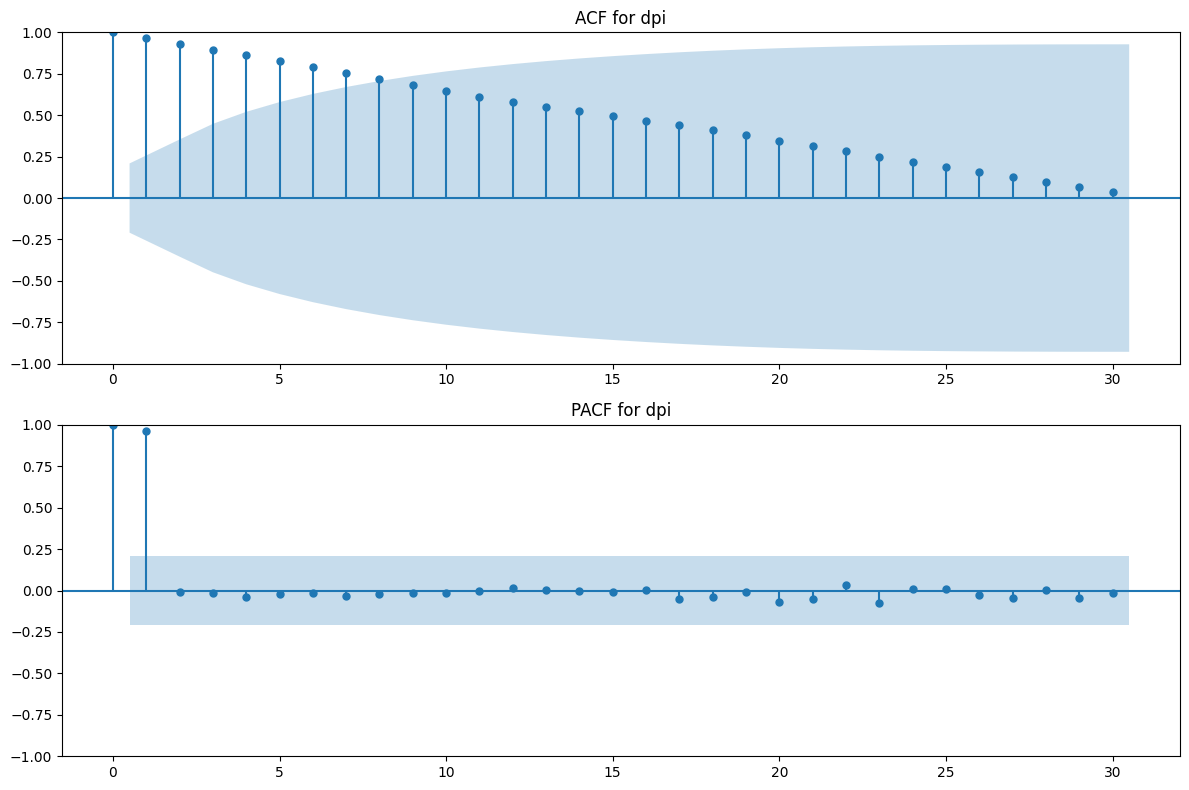


Correlogram Interpretation for dpi:
  - ACF: Shows total correlation at each lag, including indirect effects
  - PACF: Shows direct correlation at each lag, controlling for earlier lags
  - Significant spikes outside the blue confidence interval suggest strong correlations
  - ACF decay pattern indicates potential ARIMA model orders
  - PACF cutoff suggests AR order, while ACF cutoff suggests MA order


In [40]:
plot_correlograms(df, "dpi")

**ACF**

En el ACF las barras decaen lentamente y varias superan las bandas de confianza, lo que es típico de no estacionariedad y respalda la necesidad de diferenciar.

**PACF**

En el PACF se observa un corte temprano (pico fuerte en el primer rezago y caída posterior), patrón compatible con una especificación ARIMA con diferencia de primer orden y componentes AR y MA bajos.

## 3. Determinar los mejores parámetros para el modelo


In [41]:
best_arima = find_best_arima(df, "dpi")


Best ARIMA model for dpi:
Order: (1, 1, 1)
AIC: -535.21
INTERPRETATION:
  - p=1: 1 autoregressive term(s)
  - d=1: 1 difference(s) needed for stationarity
  - q=1: 1 moving average term(s)


Tomando en cuenta los resultados de las pruebas de raiz unitaria y los correlogramas, se busca mediante la función find_best_arima la mejor combinación de hiperparámetros para los términos AR y MA. Al explorar combinaciones (p,d,q), el barrido identifica como mejor especificación a ARIMA(1,1,1) con AIC = −535.21. Por lo tanto, una diferencia para lograr estacionariedad y un término AR y uno MA explican la dinámica remanente.

In [42]:
model = ARIMA(df, order=best_arima)

## 4. Entrenamiento el modelo

In [43]:
model_fit = model.fit()

In [44]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    DPI   No. Observations:                   88
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 270.603
Date:                Sun, 02 Nov 2025   AIC                           -535.206
Time:                        23:01:02   BIC                           -527.808
Sample:                             0   HQIC                          -532.227
                                 - 88                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9997      0.004    227.570      0.000       0.991       1.008
ma.L1         -0.9856      0.122     -8.047      0.000      -1.226      -0.746
sigma2         0.0001   1.75e-05      6.469      0.0

El modelo obtiene AIC = −535.206, BIC = −527.808 y HQIC = −532.227. Estos valores respaldan que, una vez diferenciada la serie, un solo término AR y uno MA bastan para capturar la dinámica de corto plazo sin sobreajustar

**AR(1)**
Con un valor de coeficiente de 0.9997, error estándar de 0.004 y p menor a 0.001, indica persistencia muy alta en la ecuación en diferencias.

**MA(1)**
Con valor de −0.9856, error estándar de 0.122 y p menor a 0.001, se observa un componente de promedio móvil casi de orden inverso al AR, lo que sugiere compensación de corto plazo típica de procesos integrados.

**Ljung-Box**
La prueba de autocorrelación con Q = 0.23, p = 0.63 indica que no hay evidencia de autocorrelación remanente al primer rezago; los errores se comportan como ruido blanco en corto plazo.

**Jarque-Bera**
La prueba da un resultado de 16.96 con p = 0.00. Esto quiere decir que los residuos no son perfectamente normales. Para pronósticos puntuales no es crítico, pero puede ensanchar o descalibrar intervalos estándar.

**Heterocedasticidad**
H = 0.40, p = 0.02. Esto da indicios de varianza no constante, se puede considerar errores robustos o un componente GARCH sobre los residuales.

## 5. Evaluación de resultados (forecast)

In [45]:
forecast_steps = 30
forecast = model_fit.forecast(steps=forecast_steps)

In [46]:
last_index = len(df) - 1
forecast_index = range(last_index + 1, last_index + 1 + forecast_steps)

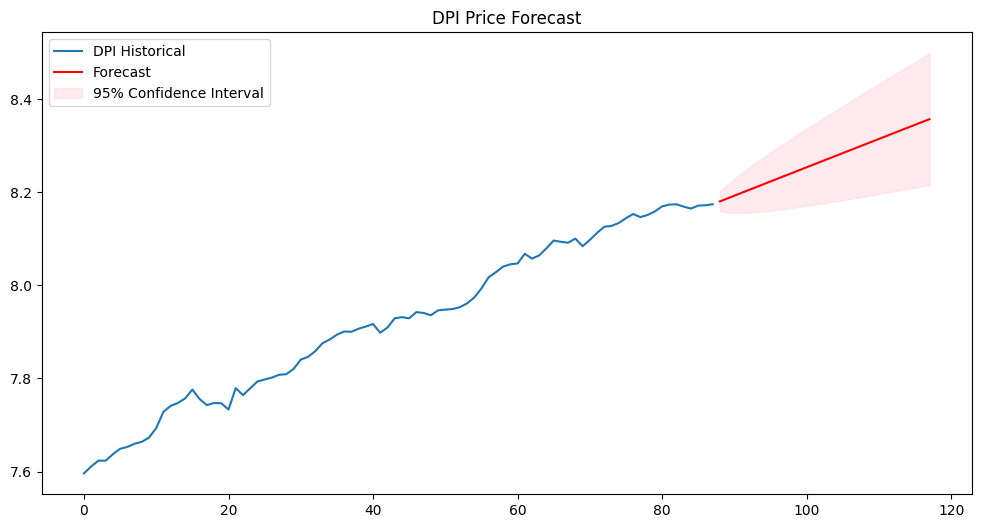


DPI Forecast Values (next 5 periods):
88    8.180114
89    8.186228
90    8.192341
91    8.198451
92    8.204561
Name: predicted_mean, dtype: float64

Forecast Interpretation for DPI:
Last observed value: 8.17
Average forecast value: 8.27
Forecast change: 0.09
Trend: Upward forecast trend
95% CI range at period 30: [8.22, 8.50]
Interpretation: The wider the confidence interval, the less certain the forecast


In [47]:
plot_forecast(model_fit, df, "DPI", forecast_steps)

El ARIMA(1,1,1) capta bien la dinámica de corto plazo tras la diferenciación, los criterios de información son competitivos para una especificación compacta, y los parámetros resultan significativos y coherentes con una alta persistencia en los cambios.

## Conclusión

La evidencia respalda un ARIMA(1,1,1). Una diferencia para lograr estacionariedad y una estructura AR MA mínima para explicar la dependencia restante. El modelo es estable y adecuado como línea base de pronóstico, proyecta trayectorias suaves con incertidumbre creciente a medida que se amplía el horizonte.